<a href="https://colab.research.google.com/github/Signorte/colab_MLDL_HandsOn/blob/master/deep_learning_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

必要なライブラリの読み込み

In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [ ]:
# 数理計算
import numpy as np

# csv読み込み
import pandas as pd

# 可視化系
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set()

# 評価指標計算
from sklearn.metrics.pairwise import cosine_similarity

# google driveとの接続
from google.colab import drive

# Deep Learning ライブラリ
from fastai.vision import *

# 0. 前回の復習



Kaggleのアニメお勧めデータベースを使用する   
https://www.kaggle.com/CooperUnion/anime-recommendations-database

Google Driveをマウントする

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# マウントしたドライブの確認
# !ls '/content/drive'
# !ls '/content/drive/My Drive'


In [ ]:
anime = pd.read_csv("/content/drive/My Drive/ai_hans_on/hans_on_3/anime.csv")
print(anime.shape)
anime.head()

(12294, 7)


anime_id                              name  ... rating members
0     32281                    Kimi no Na wa.  ...   9.37  200630
1      5114  Fullmetal Alchemist: Brotherhood  ...   9.26  793665
2     28977                          Gintama°  ...   9.25  114262
3      9253                       Steins;Gate  ...   9.17  673572
4      9969                     Gintama&#039;  ...   9.16  151266

[5 rows x 7 columns]

In [ ]:
rating = pd.read_csv("/content/drive/My Drive/ai_hans_on/hans_on_3/rating.csv")
print(rating.shape)
rating.head()

(7813737, 3)


user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

##### 問題1
`anime` と `rating` に欠損値があるか確認してみてください

In [ ]:
anime.isnull().sum(0)

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

##### 解答

In [ ]:
anime.isnull().sum(0)

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [ ]:
rating.isnull().sum(0)

user_id     0
anime_id    0
rating      0
dtype: int64

##### 問題2
欠損値を補完して上書きして下さい

In [ ]:
anime = anime.dropna()

##### 解答

In [ ]:
anime = anime.dropna()

In [ ]:
anime.isnull().sum(0)  # 再度確認

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

##### 問題3

rating内のratingのヒストグラムを可視化してみましょう

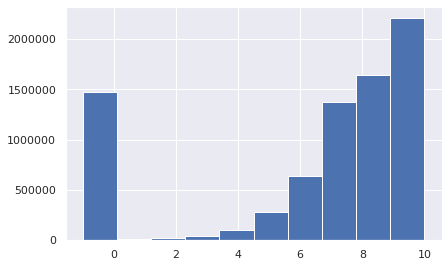

In [ ]:
rating["rating"].hist()

##### 解答

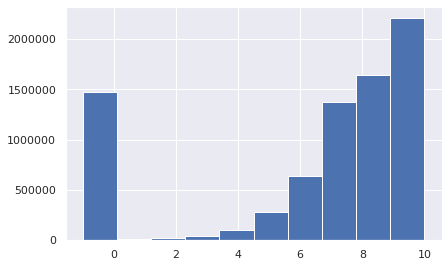

In [ ]:
rating["rating"].hist()

##### 問題４
`anime` を10,000人以上が見ているアニメに絞りましょう

In [ ]:
anime = anime[anime["members"] > 10000]
anime.shape

(2946, 7)

##### 解答

In [ ]:
anime = anime[anime["members"] > 10000]
anime.shape

(2946, 7)

##### 問題5
ratingから評価していない行(rating == -1)を除きましょう

In [ ]:
rating = rating[rating["rating"] != -1]
rating.shape

(6337241, 3)

##### 解答

In [ ]:
rating = rating[rating["rating"] != -1]
rating.shape

(6337241, 3)

##### データを連結して使用する列を絞る

In [ ]:
anime_data = rating.merge(anime, left_on='anime_id', right_on='anime_id', suffixes= ['_user', ''])
anime_data = anime_data[['user_id','name','rating_user']]
anime_data.head()

user_id                    name  rating_user
0        1  Highschool of the Dead           10
1        3  Highschool of the Dead            6
2        5  Highschool of the Dead            2
3       12  Highschool of the Dead            6
4       14  Highschool of the Dead            6

##### 問題6
データの重複を確認してみてください

In [ ]:
isData = anime_data.duplicated(keep=False, subset=['user_id', 'name'])
isData

0          False
1          False
2          False
3          False
4          False
           ...  
5956999    False
5957000    False
5957001    False
5957002    False
5957003    False
Length: 5957004, dtype: bool

##### ヒント

下記コードで `df` の `A`, `B`, `C`行が重複しているか否かをTrue/Falseで得られます
```python
df.duplicated(keep=False, subset=['A','B', 'C'])
```

##### ヒント

`df[isData]`で`df`の`isData==True`行のみ取り出せます

##### 解答

In [ ]:
isData = anime_data.duplicated(keep=False, subset=['user_id','name'])
isData

0          False
1          False
2          False
3          False
4          False
           ...  
5956999    False
5957000    False
5957001    False
5957002    False
5957003    False
Length: 5957004, dtype: bool

In [ ]:
anime_data[isData]

user_id                             name  rating_user
48054      42653                 Sword Art Online            8
48055      42653                 Sword Art Online            5
444785     42653               Shingeki no Kyojin            8
444786     42653               Shingeki no Kyojin            8
523332     42653                         Noragami            7
523333     42653                         Noragami            9
574059     42653                      Tokyo Ghoul            8
574060     42653                      Tokyo Ghoul            6
2333281    42653  Code Geass: Hangyaku no Lelouch            8
2333282    42653  Code Geass: Hangyaku no Lelouch            6
3369715    42653       Tengen Toppa Gurren Lagann            8
3369716    42653       Tengen Toppa Gurren Lagann           10
3632133    42653                Zankyou no Terror            8
3632134    42653                Zankyou no Terror            9

##### 問題7
重複を除去してください

In [ ]:
anime_data = anime_data.drop_duplicates(keep="last", subset=['user_id','name'])
anime_data.shape

(5956997, 3)

##### ヒント

下記コードで `df` の `A`, `B`, `C`行が重複しているデータを除去できます
```python
df.drop_duplicates(subset=['A','B', 'C'])
```

##### 解答

In [ ]:
anime_data = anime_data.drop_duplicates(keep="last", subset=['user_id','name'])
anime_data.shape

(5956997, 3)

##### タイトルごとのユーザー評価テーブルを作成します

縦にname 横にuser_id をとって値を rating_user とする（空欄は0で埋める）


In [ ]:
anime_data_pivot = anime_data.pivot(index='name', columns='user_id', values='rating_user').fillna(0) 
anime_data_pivot.head()

user_id                                             1      2      ...  73515  73516
name                                                              ...              
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...    0.0    0.0  ...    0.0    0.0
&quot;Bungaku Shoujo&quot; Memoire                    0.0    0.0  ...    0.0    0.0
&quot;Bungaku Shoujo&quot; Movie                      0.0    0.0  ...    0.0    0.0
.hack//G.U. Returner                                  0.0    0.0  ...    0.0    0.0
.hack//G.U. Trilogy                                   0.0    0.0  ...    0.0    0.0

[5 rows x 69498 columns]

##### 問題8
cos類似度を使ってアニメ間の距離を計算します  
`Tenkuu no Shiro Laputa`と`Tonari no Totoro`の距離を計算して下さい

In [ ]:
target_row = anime_data_pivot.iloc[anime_data_pivot.index == "Tenkuu no Shiro Laputa"]
vec1 = target_row.values
vec1

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.]])

##### ヒント

下記コードで`Dragon Ball Z`の行を取得できます
```python
anime_data_pivot.iloc[anime_data_pivot.index == "Dragon Ball Z"]
```

##### ヒント

下記コードでrow_dfをベクトル化できます
```python
row_df.values
```

##### 解答

ラピュタ

In [ ]:
target_row = anime_data_pivot.iloc[anime_data_pivot.index == "Tenkuu no Shiro Laputa"]
vec1 = target_row.values
vec1

array([[0., 0., 0., ..., 0., 0., 0.]])

トトロ

In [ ]:
target_row = anime_data_pivot.iloc[anime_data_pivot.index == "Tonari no Totoro"]
vec2 = target_row.values
vec2

array([[0., 0., 0., 0., ..., 8., 0., 8., 0.]])

cos類似度計算

In [ ]:
cosine_similarity(vec1, vec2)

array([[0.535743]])

##### 問題9
すべてのアニメと`Tonari no Totoro`のcos類似度を計算して、値を`sim_all`に代入して下さい

In [ ]:
all_vecs = anime_data_pivot.values  # すべてのデータをベクトル化
sim_all = cosine_similarity(vec2, all_vecs)
sim_all

array([[0.106659, 0.10551 , 0.131546, 0.059749, ..., 0.187663, 0.178014, 0.137287, 0.150047]])

##### 解答

In [ ]:
all_vecs = anime_data_pivot.values  # すべてのデータをベクトル化
sim_all = cosine_similarity(vec2, all_vecs)
sim_all

array([[0.10665919, 0.1055098 , 0.13154639, ..., 0.17801393, 0.13728737,
        0.15004745]])

##### 問題10
`Tonari no Totoro`と類似するアニメ上位5件を表示して下さい

In [ ]:
sort_i = sim_all[0].argsort()[::-1]  # 降順にソートしたときのインデックスを持ってくる

count = 0
for idx in sort_i:
  count += 1
  if count == 1:  # 1番近いのは自分自身なのでスキップ
    continue
  print("類似度:", sim_all[0][idx])
  print("タイトル:", anime_data_pivot.index[idx])
  print()
  if count > 5:  # 5件以上表示したら抜ける
    break

類似度: 0.6144139466596494
タイトル: Sen to Chihiro no Kamikakushi

類似度: 0.6053342026080479
タイトル: Howl no Ugoku Shiro

類似度: 0.5605612245320922
タイトル: Majo no Takkyuubin

類似度: 0.5585146257071234
タイトル: Mononoke Hime

類似度: 0.5357429442718246
タイトル: Tenkuu no Shiro Laputa



##### ヒント

下記で`sim_all`の値を降順にソートしたときのインデックスを返すことができます
```python
sim_all[0].argsort()[::-1]
```

##### ヒント

下記で`idx`番目のアニメのタイトルを取得できます
```python
anime_data_pivot.index[idx]
```

##### 解答

In [ ]:
sort_i = sim_all[0].argsort()[::-1]  # 降順にソートしたときのインデックスを持ってくる

count = 0
for idx in sort_i:
  count += 1
  if count == 1:  # 1番近いのは自分自身なのでスキップ
    continue
  print("類似度:", sim_all[0][idx])
  print("タイトル:", anime_data_pivot.index[idx])
  print()
  if count > 5:  # 5件以上表示したら抜ける
    break

類似度: 0.6144139466596494
タイトル: Sen to Chihiro no Kamikakushi

類似度: 0.6053342026080479
タイトル: Howl no Ugoku Shiro

類似度: 0.5605612245320922
タイトル: Majo no Takkyuubin

類似度: 0.5585146257071234
タイトル: Mononoke Hime

類似度: 0.5357429442718246
タイトル: Tenkuu no Shiro Laputa



# Deep Learning体験

学習するデータ(犬猫画像)をダウンロード

In [ ]:
path = untar_data(URLs.PETS)
path # ダウンロード先の確認

PosixPath('/root/.fastai/data/oxford-iiit-pet')

中のフォルダの確認

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

`images`ファイル内のパスを取得する

In [ ]:
fnames = get_image_files(path/'images')
fnames[:5]  # 先頭5件を表示

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_77.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_267.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_134.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_167.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_53.jpg')]

In [ ]:
len(fnames)

7390

学習用データセットを定義

In [ ]:
data = ImageDataBunch.from_name_re(
    path/'images',  # 画像があるフォルダのパス
    fnames,  # 画像パスのリスト
    r'/([^/]+)_\d+.jpg$',  # 画像ファイル名からラベルをつける正規表現
    ds_tfms=None,  # データ増強(一旦無視)
    size=128, # 画像サイズ
    bs=64,  # バッチサイズ→スライドで説明
    ).normalize(imagenet_stats)

どのようなデータか確認

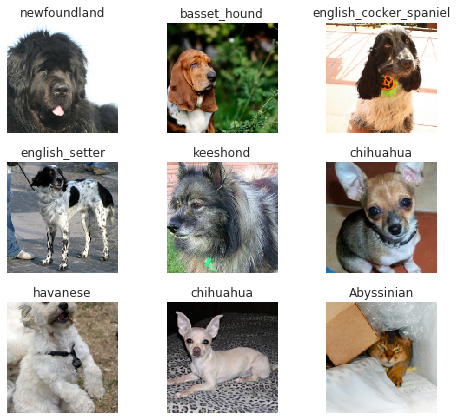

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

ラベルの種類

In [ ]:
data.classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [ ]:
len(data.classes)

37

ニューラルネットワークの定義

In [ ]:
model = simple_cnn((3, 16, 16, 2))
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
  )
)

##### 演習
3チャンネル、32→32、出力37のCNNを定義してみましょう

In [ ]:
model = simple_cnn((3, 32, 32, 37))
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 37, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
  )
)

##### 解答

In [ ]:
model = simple_cnn((3, 32, 32, 37))
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 37, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
  )
)

##### 学習を行う

データとモデルを扱うlernerを定義

In [ ]:
learn = Learner(data, model)

1 epoch 学習する

In [ ]:
learn.fit(1)

2 epoch 学習する

In [ ]:
learn.fit(2) 
# train_lossが下がって、valid_lossが下がっていかなくなったら過学習の可能性あり

モデルがどのような予測をするか確認する

評価データの予測を行う

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

間違えているものを確認する

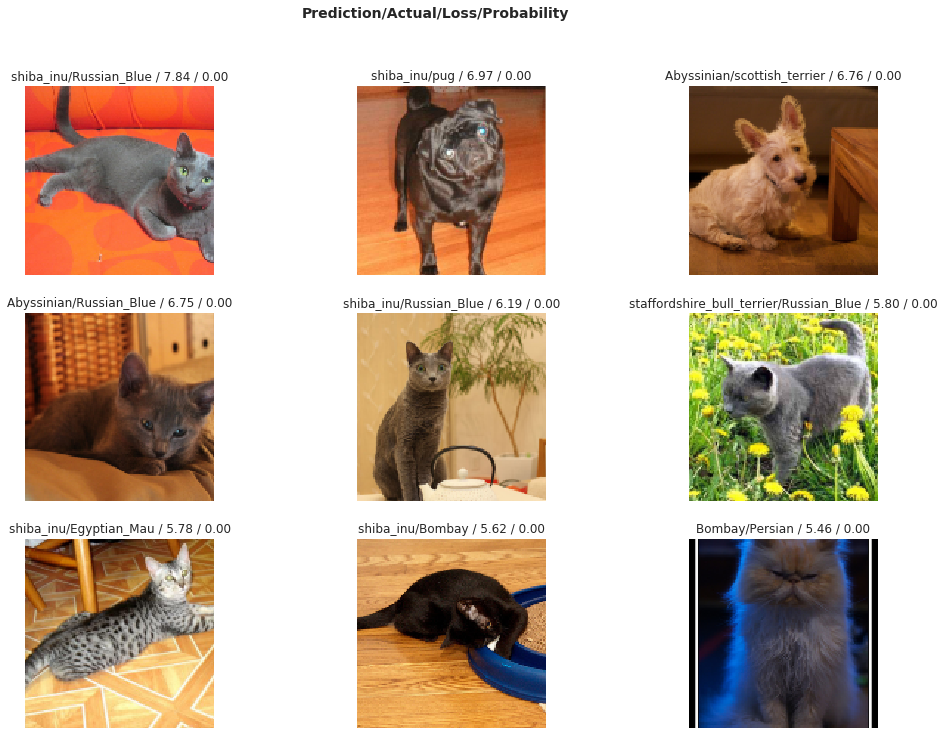

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

間違えやすいペアを確認する

In [ ]:
interp.most_confused(min_val=3)  # 三回以上間違えているペア

[('Russian_Blue', 'japanese_chin', 16),
 ('great_pyrenees', 'japanese_chin', 16),
 ('Maine_Coon', 'japanese_chin', 15),
 ('american_bulldog', 'japanese_chin', 15),
 ('basset_hound', 'japanese_chin', 14),
 ('samoyed', 'japanese_chin', 13),
 ('keeshond', 'japanese_chin', 12),
 ('Egyptian_Mau', 'japanese_chin', 11),
 ('miniature_pinscher', 'japanese_chin', 11),
 ('pomeranian', 'Persian', 11),
 ('saint_bernard', 'japanese_chin', 11),
 ('yorkshire_terrier', 'shiba_inu', 11),
 ('Ragdoll', 'japanese_chin', 10),
 ('Sphynx', 'japanese_chin', 10),
 ('beagle', 'japanese_chin', 10),
 ('pomeranian', 'japanese_chin', 10),
 ('saint_bernard', 'boxer', 10),
 ('wheaten_terrier', 'shiba_inu', 10),
 ('Abyssinian', 'shiba_inu', 9),
 ('Birman', 'japanese_chin', 9),
 ('Bombay', 'japanese_chin', 9),
 ('British_Shorthair', 'japanese_chin', 9),
 ('havanese', 'shiba_inu', 9),
 ('pug', 'japanese_chin', 9),
 ('Siamese', 'japanese_chin', 8),
 ('boxer', 'japanese_chin', 8),
 ('chihuahua', 'japanese_chin', 8),
 ('whe

混同行列

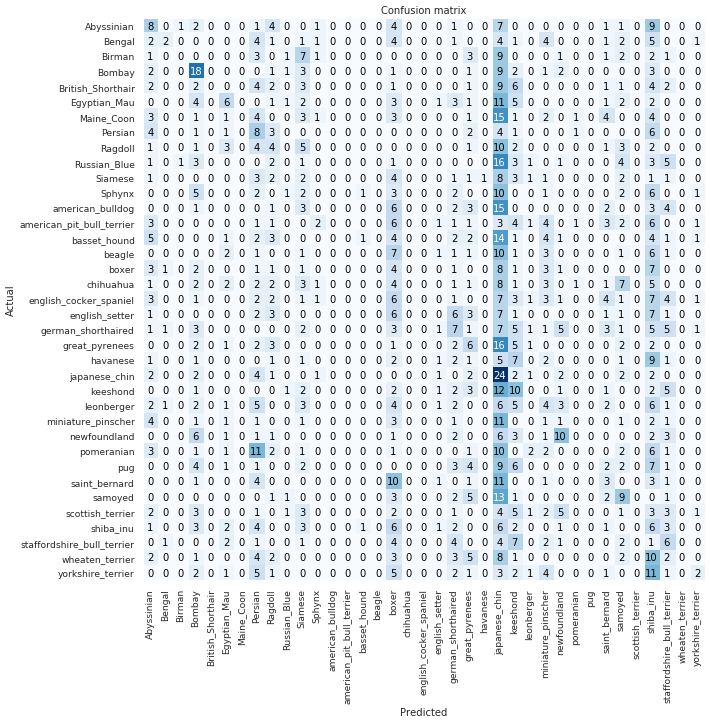

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## 精度を上げる

### 1. 転移学習(→詳細スライド)

imagenetというデータを学習したResnet34というモデルを転用する

In [ ]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 79.7MB/s]


In [ ]:
learn.fit(3)

##### 演習
モデルがどのような予測を行っているか確認してみて下さい

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


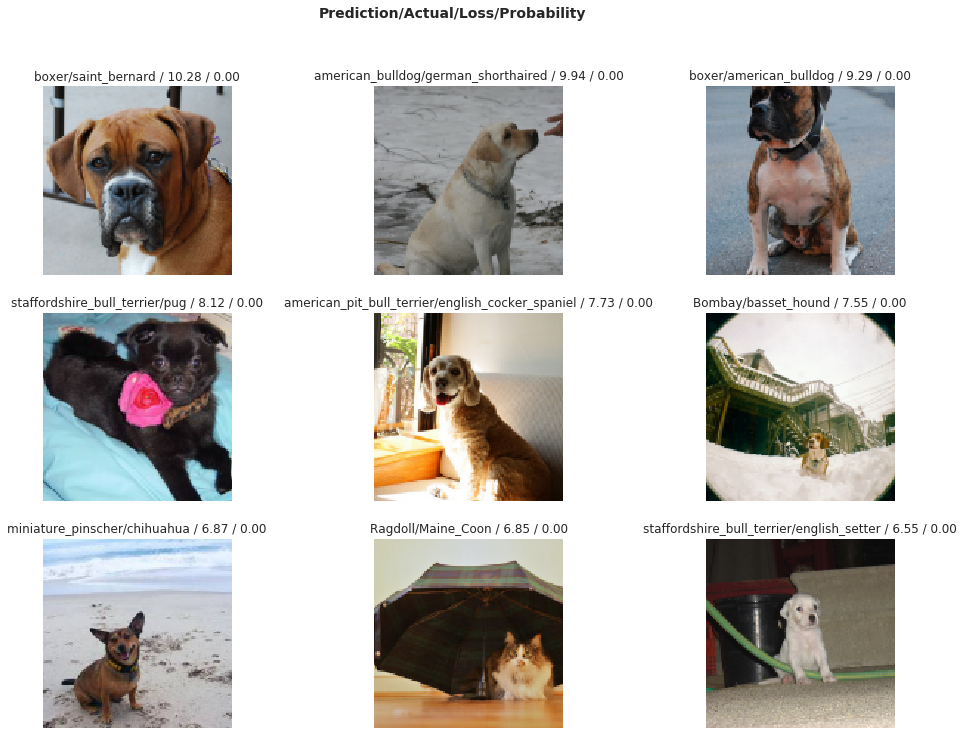

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

##### 解答

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

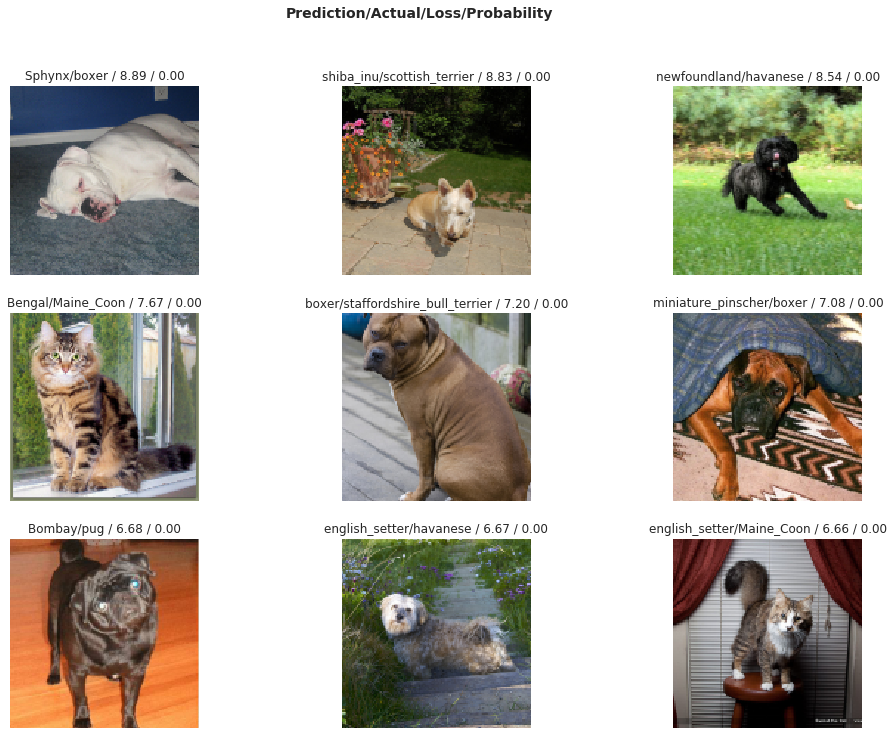

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.most_confused(min_val=3)  # 三回以上間違えているペア

[('British_Shorthair', 'Russian_Blue', 9),
 ('Ragdoll', 'Birman', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('english_cocker_spaniel', 'havanese', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Persian', 'Maine_Coon', 5),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('scottish_terrier', 'havanese', 5),
 ('Abyssinian', 'Bengal', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Abyssinian', 'Maine_Coon', 3),
 ('Bengal', 'Maine_Coon', 3),
 ('Birman', 'Ragdoll', 3),
 ('Siamese', 'Birman', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_bulldog', 'beagle', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('american_pit_bull_terrier', 'german_shorthaired', 3),
 ('beagle', 'basset_hound', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('great_pyrenees', 'havanese', 3),
 ('samoyed', 'Persian', 3),
 ('yorkshire_terrier', 'havanese', 3)]

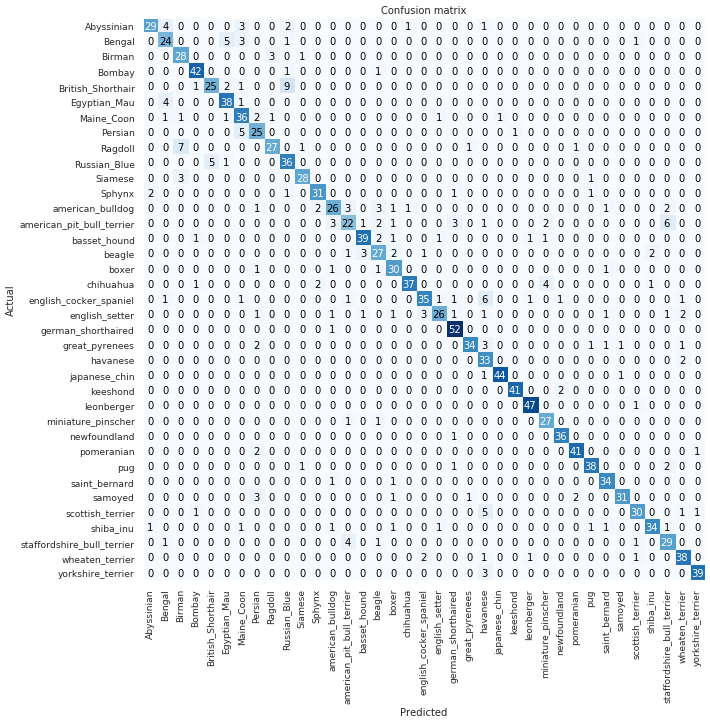

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

##### ハイパーパラメータ(学習率)を調整する

最適な学習率を探索する

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 1.20E-02


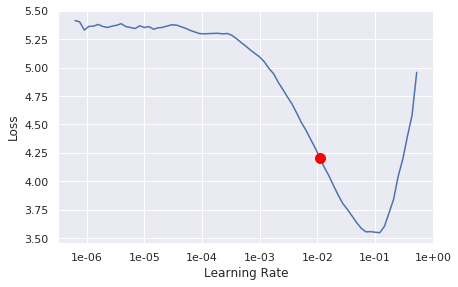

In [ ]:
learn = cnn_learner(data, models.resnet34)  # モデルの定義

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3, 1e-2)  # デフォルトは0.003

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

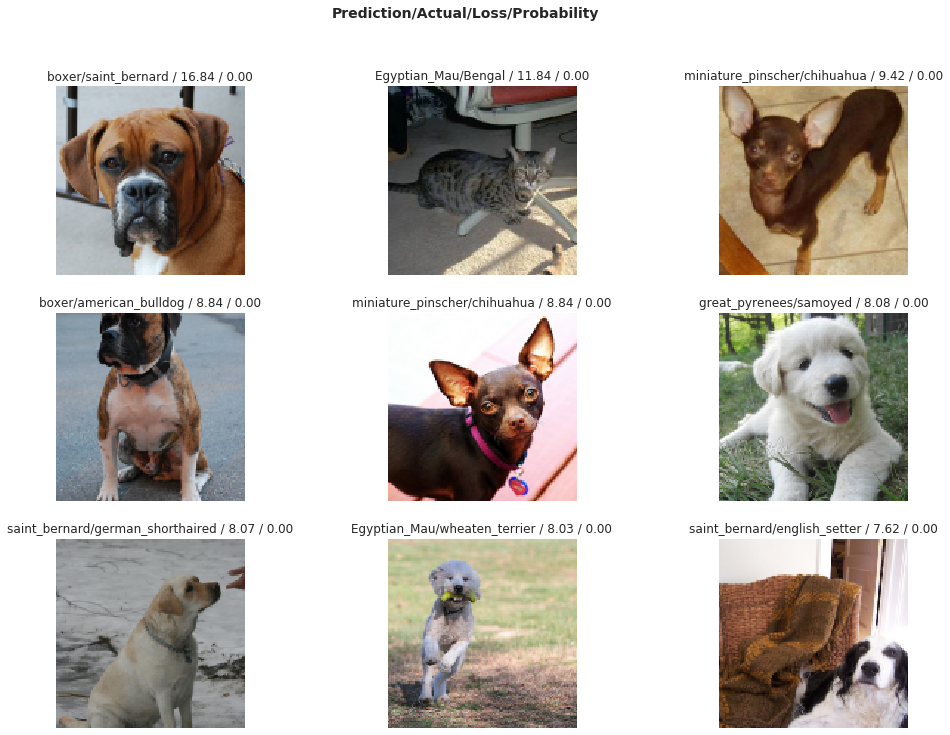

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.most_confused(min_val=3)

[('english_cocker_spaniel', 'english_setter', 8),
 ('British_Shorthair', 'Russian_Blue', 6),
 ('Ragdoll', 'Birman', 6),
 ('Russian_Blue', 'British_Shorthair', 6),
 ('Persian', 'Maine_Coon', 5),
 ('Siamese', 'Birman', 5),
 ('chihuahua', 'miniature_pinscher', 5),
 ('Maine_Coon', 'Ragdoll', 4),
 ('american_pit_bull_terrier', 'miniature_pinscher', 4),
 ('english_cocker_spaniel', 'wheaten_terrier', 4),
 ('yorkshire_terrier', 'havanese', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('american_bulldog', 'boxer', 3),
 ('basset_hound', 'saint_bernard', 3),
 ('english_setter', 'saint_bernard', 3),
 ('pug', 'staffordshire_bull_terrier', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3)]

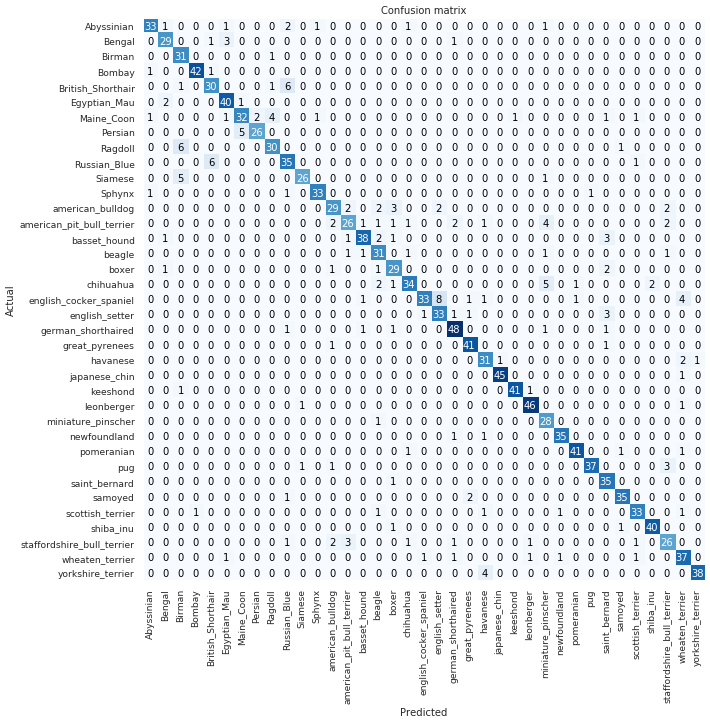

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## データ増強

In [ ]:
tfms = get_transforms(
    do_flip=True,  # Trueなら1/2の確率で水平反転される
    flip_vert=False,  # Trueなら1/2の確率で垂直反転する
    max_rotate=10.0, # 最大max_rotateの回転が適用される
    max_zoom=1.1,  # 最大max_zoomの拡大が適用される
    max_lighting=0.5, # コントラスト変換が適用される確率
    max_warp=0.2,  # ワープ変換(歪み)が-max_warp〜maw_warpの間で適用される
    p_affine=0.75,  # 回転、拡大、ワープ変換が適用される確率
    p_lighting=0.75  # コントラスト変換が適用される確率
)

In [ ]:
data = ImageDataBunch.from_name_re(
    path/'images',  # 画像があるフォルダのパス
    fnames,  # 画像パスのリスト
    r'/([^/]+)_\d+.jpg$',  # 画像ファイル名からラベルをつける正規表現
    ds_tfms=tfms,  # データ増強
    size=128, # 画像サイズ
    bs=64,  # バッチサイズ→スライドで説明
    padding_mode='zeros',
    ).normalize(imagenet_stats)

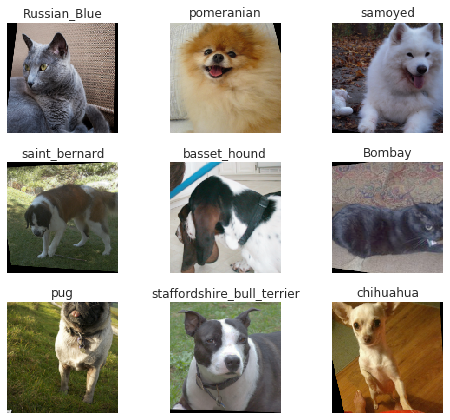

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
learn = cnn_learner(data, models.resnet34)  # モデルの定義

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 8.32E-03


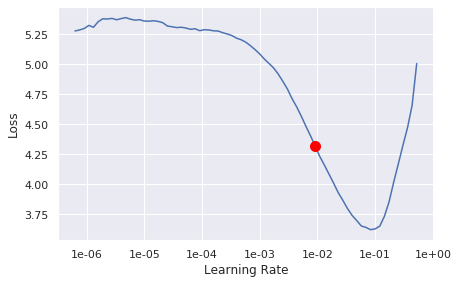

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3, 8.32e-3)  # デフォルト0.003→8.32E-03

評価

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

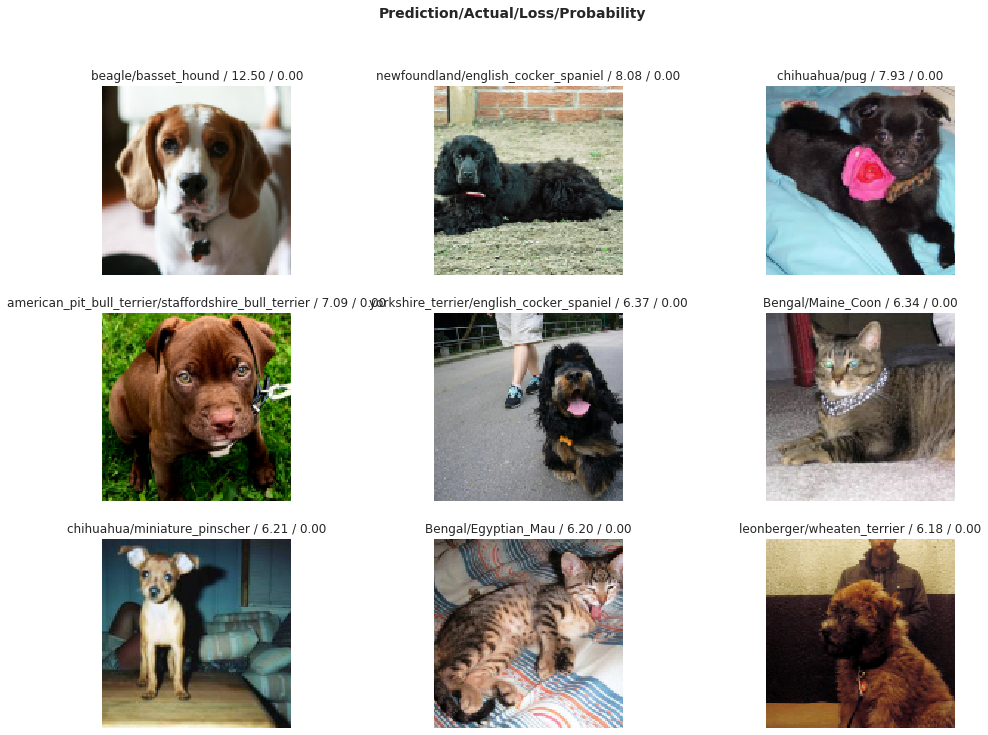

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.most_confused(min_val=3)

[('Egyptian_Mau', 'Bengal', 9),
 ('english_setter', 'english_cocker_spaniel', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('British_Shorthair', 'Russian_Blue', 6),
 ('Maine_Coon', 'Persian', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('basset_hound', 'beagle', 4),
 ('english_cocker_spaniel', 'english_setter', 4),
 ('wheaten_terrier', 'leonberger', 4),
 ('Birman', 'Siamese', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('Ragdoll', 'Birman', 3),
 ('Russian_Blue', 'Bombay', 3),
 ('Siamese', 'Ragdoll', 3),
 ('american_bulldog', 'beagle', 3),
 ('beagle', 'basset_hound', 3),
 ('boxer', 'american_bulldog', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('havanese', 'english_cocker_spaniel', 3),
 ('samoyed', 'great_pyrenees', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'boxer', 3),
 ('staffordshire_bull_terrier', 'german_shorthaired', 3)]

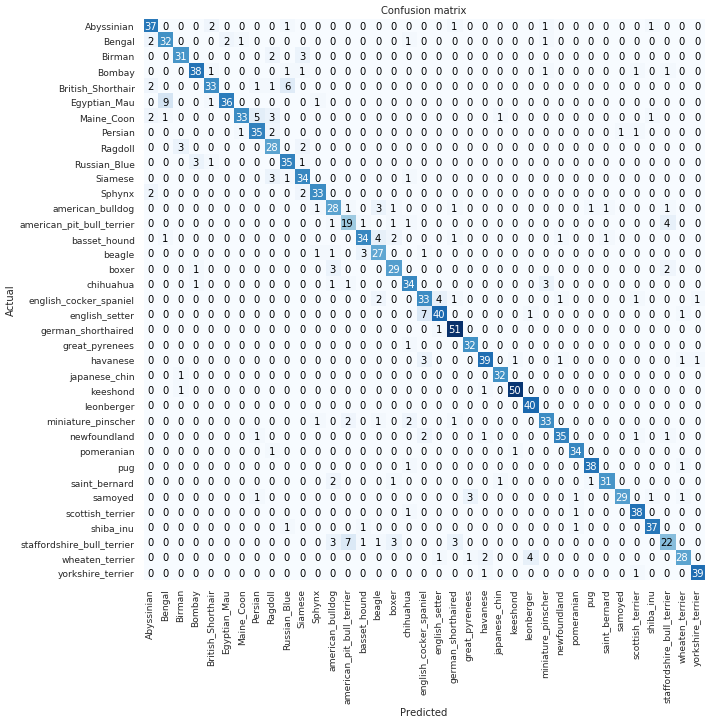

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
## 文字認識(MNIST)

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=None, size=26)

In [ ]:
learn = cnn_learner(data, models.resnet34)  # モデルの定義

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 3.02E-02


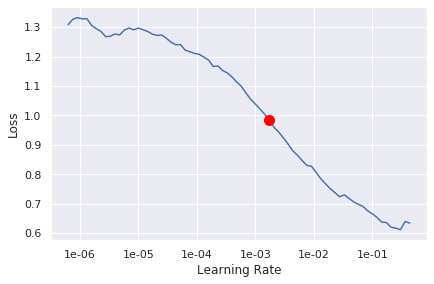

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
tfms = get_transforms(
    do_flip=True,  # Trueなら1/2の確率で水平反転される
    flip_vert=False,  # Trueなら1/2の確率で垂直反転する
    max_rotate=10.0, # 最大max_rotateの回転が適用される
    max_zoom=1.1,  # 最大max_zoomの拡大が適用される
    max_lighting=0.5, # コントラスト変換が適用される確率
    max_warp=0.2,  # ワープ変換(歪み)が-max_warp〜maw_warpの間で適用される
    p_affine=0.75,  # 回転、拡大、ワープ変換が適用される確率
    p_lighting=0.75  # コントラスト変換が適用される確率
)

In [ ]:
data = ImageDataBunch.from_name_re(
    # path/'images',  # 画像があるフォルダのパス
    # fnames,  # 画像パスのリスト
    r'/([^/]+)_\d+.jpg$',  # 画像ファイル名からラベルをつける正規表現
    ds_tfms=tfms,  # データ増強
    size=128, # 画像サイズ
    bs=64,  # バッチサイズ→スライドで説明
    padding_mode='zeros',
    ).normalize(imagenet_stats)

TypeError: ignored

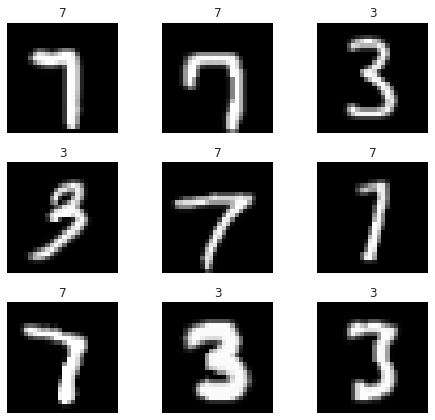

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
learn.fit_one_cycle(3, 3.02E-02)  # デフォルト0.003→3.02E-02

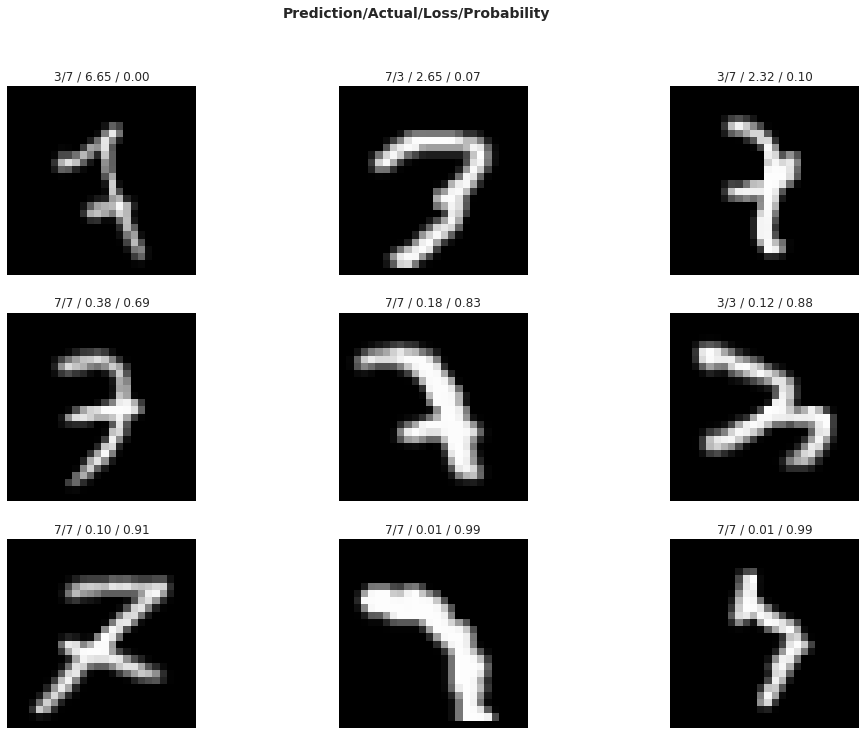

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.most_confused(min_val=3)

[]

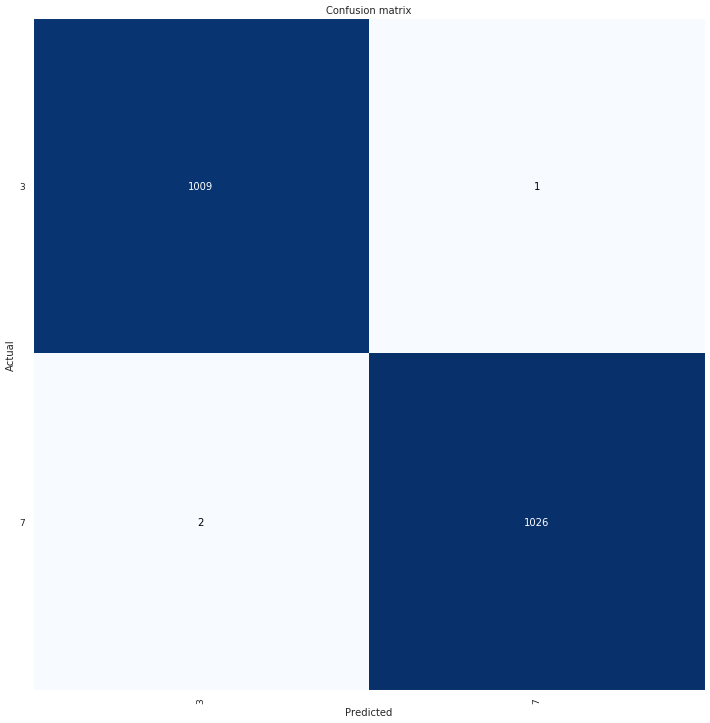

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)